In [1]:
import numpy as np
import seaborn as sns


# Heatmap Example

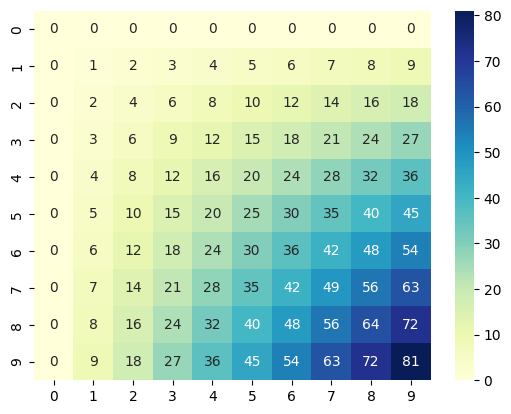

In [2]:
def generate_heatmap_data():
    # Generate a 10x10 matrix of random numbers
    data = [[i * j for j in range(10)] for i in range(10)]
    return data

def plot_heatmap(data):
    # Create a heatmap using seaborn
    sns.heatmap(data, annot=True, fmt="d", cmap="YlGnBu")

# Generate the data
data = generate_heatmap_data()

# Plot the heatmap
heatmap = plot_heatmap(data)


In [3]:
from env import TwoRooms, FourRooms

def state_to_coords(env, state, dim):
    """
    Convert a state number to (x, y) coordinates.

    Parameters:
    state_num (int): The state number
    has_wall (bool): Whether there's a wall

    Returns:
    tuple: (row, col) coordinates
    """
    # Convert state number to coordinates
    row = state // dim
    col = state % dim

    if isinstance(env, TwoRooms):
        if state in [
            6,  7,  8,  9, 10, 11,
            18, 19, 20, 21, 22, 23,
            30, 31, 32, 33, 34, 35,
            42, 43, 44, 45, 46, 47,
            54, 55, 56, 57, 58, 59,
            66, 67,  68, 69, 70, 71
        ]:
            col += 1
    elif isinstance(env, FourRooms):
        if state in [
            5,  6,  7,  8,  9,
            15, 16, 17, 18, 19,
            25, 26, 27, 28, 29,
            35, 36, 37, 38, 39,
            45, 46, 47, 48, 49,
            55, 56, 57, 58, 59,
            65, 66, 67, 68, 69,
            75, 76, 77, 78, 79,
            85, 86, 87, 88, 89,
            95, 96, 97, 98, 99
            ]:
            col += 1
        if state in [
            50, 51, 52, 53, 54,
            60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
            70, 71, 72, 73, 74, 75, 76, 77, 78, 79,
            80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
            90, 91, 92, 93, 94, 95, 96, 97, 98, 99
        ]:
            row += 1

    return row, col


def plot_heatmap_from_state_scores(env, state_scores: dict):
    """
    Plot a heatmap of state scores (different metrics) for a given environment.
    """

    # Get the size of the environment
    size = env.size
    wall_col = size[0] // 2
    rows, cols = size

    if isinstance(env, TwoRooms):
        dim = 12
        cols += 1
    elif isinstance(env, FourRooms):
        dim = 10
        cols += 1
        rows += 1

    # Initialize the data grid
    data = np.zeros((rows, cols))

    # Walls
    data[:, wall_col] = -1.
    if isinstance(env, FourRooms):
        data[5, :5] = -1.
        data[6, 6:] = -1.

    # Hallways
    data[2, wall_col] = 0.0
    if isinstance(env, FourRooms):
        data[5, 1] = 0.0
        data[6, 8] = 0.0
        data[9, wall_col] = 0.0

    for state, score in state_scores.items():

        if isinstance(env, TwoRooms) and state == 68:
            row, col = 2, 6
        elif isinstance(env, FourRooms) and state == 75:
            row, col = 5, 1
        elif isinstance(env, FourRooms) and state == 100:
            row, col = 2, 5
        elif isinstance(env, FourRooms) and state == 101:
            row, col = 6, 8
        elif isinstance(env, FourRooms) and state == 102:
            row, col = 9, 5
        else:
            row, col = state_to_coords(env, state, dim)
        data[row, col] = score

    sns.heatmap(data)


# Sample Trajectories

In [4]:
from agent import SMDPQLearning
from env import FourRooms, TwoRooms, get_primitive_actions_as_options
from trajectory_sampler import sample


In [5]:
# Start states
tworooms_default_s0 = 24

tworooms_left_room = [
    0, 1, 2, 3, 4, 5,
    12, 13, 14, 15, 16, 17,
    24, 25, 26, 27, 28, 29,
    36, 37, 38, 39, 40, 41,
    48, 49, 50, 51, 52, 53,
    60, 61, 62, 63, 64, 65,
]

fourrooms_default_s0 = 30

fourrooms_first_room = [
    0, 1, 2, 3, 4,
    10, 11, 12, 13, 14,
    20, 21, 22, 23, 24,
    30, 31, 32, 33, 34,
    40, 41, 42, 43, 44,
]

# Create the environment
tworooms = TwoRooms(
    start_state=tworooms_default_s0,
    goal_state=68,
    negative_states_config="none",
    max_steps=None
)

fourrooms = FourRooms(
    start_state=fourrooms_first_room,
    goal_state=75,
    negative_states_config="default",
    max_steps=None,
    sparse_rewards=True
)

env = tworooms

# Set up the agent with primitive options (actions)
primitive_options = get_primitive_actions_as_options(env)

agent = SMDPQLearning(
    env,
    primitive_options,
    learning_rate=0.1,
    discount_factor=0.99,
    exploration_rate=0.1,
    min_exploration_rate=0.1,
    exploration_decay=1
)

# Sample trajectories
print("Sampling trajectories...")
n_samples = 50
trajectories, results, steps = sample(env, agent, n_samples)


Sampling trajectories...


100%|██████████| 50/50 [00:00<00:00, 51.86it/s]


In [6]:
all(results)

True

# Heatmaps

## Every visit X First visit

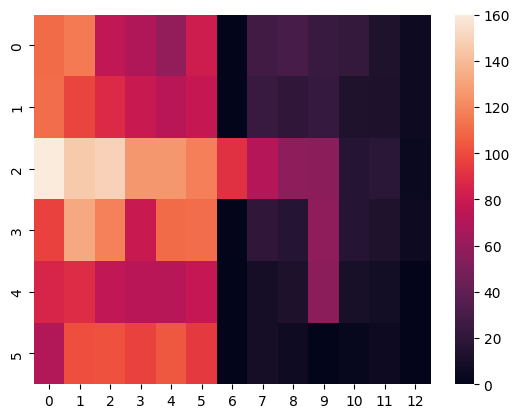

In [7]:
every_visit_scores = {s: 0.0 for s in range(env.observation_space.n)}
for t in trajectories:
    for s in t:
        if s == env.goal_transition_state:
            continue
        every_visit_scores[s] += 1.0

plot_heatmap_from_state_scores(env, every_visit_scores)


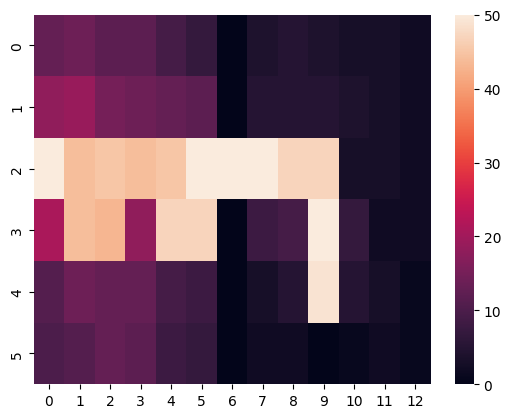

In [8]:
first_visit_scores = {s: 0.0 for s in range(env.observation_space.n)}
for t in trajectories:
    visited = set()
    for s in t:
        if s == env.goal_transition_state or s in visited:
            continue
        first_visit_scores[s] += 1.0
        visited.add(s)

plot_heatmap_from_state_scores(env, first_visit_scores)


## Diverse Density

In [9]:
# from subgoal_discovery import diverse_density
from tmp.diverse_density_claude import diverse_density, running_average_dd, validate_diverse_density_implementation

validate_diverse_density_implementation(trajectories, results)

=== Diverse Density Implementation Validation ===
Trajectory Statistics: {'total_trajectories': 50, 'successful_trajectories': 50, 'failed_trajectories': 0, 'success_rate': 1.0, 'avg_successful_length': np.float64(87.6), 'avg_failed_length': 0}
Average original trajectory length: 87.60
Average first-visit trajectory length: 24.68


True

In [10]:
persistent_subgoals = running_average_dd(trajectories, results, lambda_value=0.9)
persistent_subgoals

{np.int64(0): 4.6953279000000006,
 np.int64(1): 4.6953279000000006,
 np.int64(2): 3.0951,
 np.int64(7): 0.9,
 np.int64(12): 1.71,
 24: 8.90302262702125,
 np.int64(25): 2.439,
 np.int64(13): 3.6855900000000004,
 np.int64(26): 0.9,
 np.int64(29): 8.852191170585655,
 np.int64(30): 8.835767967317395}

In [11]:
dd_tuples = diverse_density(trajectories, results, threshold=0.0)
dd_scores = {s: 0.0 for s in range(env.observation_space.n)}
for s, dd in dd_tuples:
    if s == env.goal_transition_state:
        continue
    dd_scores[s] = dd

dd_scores[25]

0.6528927522996982

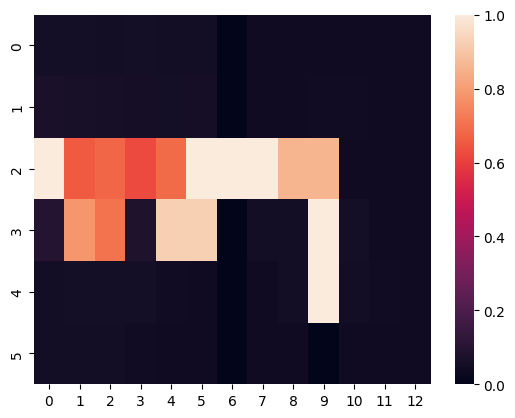

In [12]:
plot_heatmap_from_state_scores(env, dd_scores)


## Relative Novelty

In [13]:
from subgoal_discovery import relative_novelty
# from tmp.relative_novelty_claude import relative_novelty


In [14]:
subgoals = relative_novelty(trajectories, novelty_lag=7)


In [15]:
rn_scores = relative_novelty(trajectories, novelty_lag=7, return_scores=True)

In [16]:
plot_heatmap_from_state_scores(env, rn_scores)


ValueError: setting an array element with a sequence.

## Empowerment

In [17]:
from empowerment import compute_empowerment, transition_matrix

In [18]:
T = transition_matrix(env)
emp_scores = {}
for s in range(env.observation_space.n):
    emp_scores[s] = compute_empowerment(T, 5, s)
emp_scores[0]

np.float64(4.392317422778761)

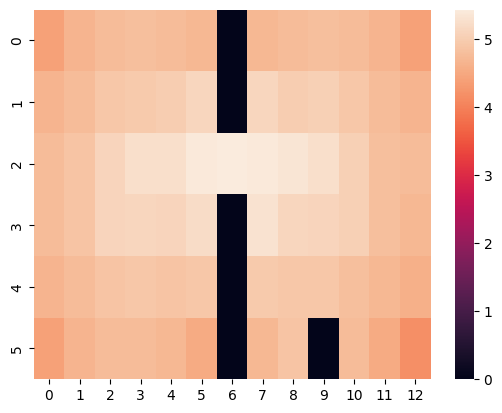

In [22]:
plot_heatmap_from_state_scores(env, emp_scores)


In [27]:
sorted(emp_scores.items(), key=lambda item: item[1], reverse=True)


[(25, np.float64(5.357552004618084)),
 (100, np.float64(5.357552004618084)),
 (24, np.float64(5.285402218862249)),
 (26, np.float64(5.285402218862249)),
 (67, np.float64(5.285402218862249)),
 (101, np.float64(5.285402218862249)),
 (57, np.float64(5.247927513443585)),
 (76, np.float64(5.247927513443585)),
 (77, np.float64(5.247927513443585)),
 (35, np.float64(5.20945336562895)),
 (37, np.float64(5.20945336562895)),
 (66, np.float64(5.20945336562895)),
 (75, np.float64(5.20945336562895)),
 (23, np.float64(5.169925001442312)),
 (27, np.float64(5.169925001442312)),
 (41, np.float64(5.169925001442312)),
 (47, np.float64(5.169925001442312)),
 (51, np.float64(5.169925001442312)),
 (36, np.float64(5.129283016944966)),
 (65, np.float64(5.129283016944966)),
 (15, np.float64(5.087462841250339)),
 (56, np.float64(5.087462841250339)),
 (102, np.float64(5.087462841250339)),
 (31, np.float64(5.044394119358453)),
 (34, np.float64(5.044394119358453)),
 (42, np.float64(5.044394119358453)),
 (58, np.floa

In [20]:
from tmp.empowerment_claude import EmpowermentCalculator, identify_empowerment_subgoals

_time_horizon = 3

# Initialize empowerment calculator
emp_calc = EmpowermentCalculator(env, time_horizon=_time_horizon)
emp_calc.update_transition_model(trajectories)

print("\nCalculating empowerments...")
# Calculate empowerments for all states
empowerments = emp_calc.calculate_all_empowerments(method="exact")

# Identify subgoals
subgoals = identify_empowerment_subgoals(empowerments)

print(f"\nTop 10 states by empowerment:")
for i, (state, emp) in enumerate(subgoals[:10], 1):
    print(f"{i}. State {state}: {emp:.4f}")

# Check specific important states
for i, trajectory in enumerate(trajectories):
    start_state = trajectory[0]
    goal_state = env.goal_state

    print(f"\nSpecific state empowerments:")
    print(f"Start state ({start_state}): {empowerments.get(start_state, 0):.4f}")
    print(f"Goal state ({goal_state}): {empowerments.get(goal_state, 0):.4f}")

    if isinstance(env, TwoRooms):
        # Check hallway state for TwoRooms
        print(f"Hallway state ({env.h}): {empowerments.get(env.h, 0):.4f}")
    elif isinstance(env, FourRooms):
        # Check hallway state for FourRooms
        # Assuming the hallway state is defined in the environment
        # This is a placeholder, adjust according to your environment's definition
        print(f"Hallway 1 state ({env.h1}): {empowerments.get(env.h1, 0):.4f}")
        print(f"Hallway 1 state ({env.h2}): {empowerments.get(env.h2, 0):.4f}")
        print(f"Hallway 1 state ({env.h3}): {empowerments.get(env.h3, 0):.4f}")
        print(f"Hallway 1 state ({env.h4}): {empowerments.get(env.h4, 0):.4f}")

# Visualize empowerment distribution
print(f"\nEmpowerment statistics:")
emp_values = list(empowerments.values())
print(f"Mean: {np.mean(emp_values):.4f}")
print(f"Std: {np.std(emp_values):.4f}")
print(f"Max: {np.max(emp_values):.4f}")
print(f"Min: {np.min(emp_values):.4f}")

subgoals


Calculating empowerments...

Top 10 states by empowerment:
1. State 76: 3.9283
2. State 25: 3.7995
3. State 77: 3.7600
4. State 24: 3.7564
5. State 57: 3.7564
6. State 67: 3.7564
7. State 35: 3.7252
8. State 66: 3.7122
9. State 42: 3.6821
10. State 52: 3.6821

Specific state empowerments:
Start state (0): 2.8419
Goal state (75): 3.5224
Hallway 1 state (75): 3.5224
Hallway 1 state (100): 3.6238
Hallway 1 state (101): 3.6238
Hallway 1 state (102): 3.3506

Specific state empowerments:
Start state (43): 3.3465
Goal state (75): 3.5224
Hallway 1 state (75): 3.5224
Hallway 1 state (100): 3.6238
Hallway 1 state (101): 3.6238
Hallway 1 state (102): 3.3506

Specific state empowerments:
Start state (40): 3.0687
Goal state (75): 3.5224
Hallway 1 state (75): 3.5224
Hallway 1 state (100): 3.6238
Hallway 1 state (101): 3.6238
Hallway 1 state (102): 3.3506

Specific state empowerments:
Start state (3): 3.3034
Goal state (75): 3.5224
Hallway 1 state (75): 3.5224
Hallway 1 state (100): 3.6238
Hallway 1

[(76, np.float64(3.92832529025077)),
 (25, np.float64(3.799483007237829)),
 (77, np.float64(3.759962303910003)),
 (24, np.float64(3.756437890016525)),
 (57, np.float64(3.756437890016525)),
 (67, np.float64(3.756437890016525)),
 (35, np.float64(3.725187890016525)),
 (66, np.float64(3.7121931183607573)),
 (42, np.float64(3.6821427727952205)),
 (52, np.float64(3.6821427727952205)),
 (74, np.float64(3.6821427727952205))]

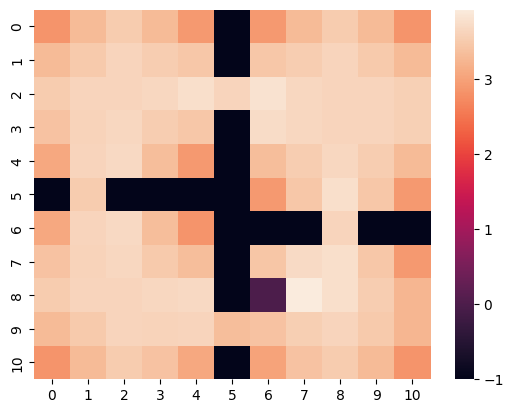

In [21]:
plot_heatmap_from_state_scores(env, empowerments)
